# TensorFlow
---

我們前面兩章都使用的簡單地梯度下降法, 這章我們試著更深入了解梯度下降, 試著解析這種做法的利弊.  
在一開始我們先試著透過新的運算來繪製誤差曲面, 這要仰賴前面的模型, 而這會幫助我們更了解整個梯度的運作.  

## 目標
* 學習讀取`pretrained model`(如果上一章練習不夠)
* 學習對`pretrained model`進行修改
* 更深刻了解`梯度 (gardient)`
* `優化器 optimization`的簡單介紹

## 索引
### [1 讀取模型](#1.-讀取模型)
### [2 修改模型](#2.-修改模型)
### [3 繪製誤差曲面](#3.-繪製誤差曲面)
### [4 優化器](#4.-優化器)
[4.1 Momentum](#4.1-Momentum)  
[4.2 AdaGrad](#4.2-AdaGrad)  
[4.3 AdaDelta](#4.3-AdaDelta)  
[4.4 RMSProp](#4.4-RMSProp)  
[4.5 Adam](#4.5-Adam)

## 1. 讀取模型

In [1]:
# 為了簡化程式碼, 我把inference, loss寫到my_model這個python程式中, 就不用在這裡定義.
from my_model import inference, loss, training, evaluate

import input_data
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 載入資料, 記得one_hot, 我常常忘記
mnist = input_data.read_data_sets('datasets', one_hot=True)

Extracting datasets\train-images-idx3-ubyte.gz
Extracting datasets\train-labels-idx1-ubyte.gz
Extracting datasets\t10k-images-idx3-ubyte.gz
Extracting datasets\t10k-labels-idx1-ubyte.gz


載入模型, 動作都跟上一章提到的一樣.  
記得x, y都要拿出來, 因為我們要用feed_dict來替換.  
千萬要記得, 不要使用新的變數去定義, 看圖會發現我們需要本來的x, y才能正確`feed`

In [3]:
sess = tf.Session()

saver = tf.train.import_meta_graph('ml_logs/model-checkpoint-42900.meta')
saver.restore(sess, tf.train.latest_checkpoint('ml_logs'))

g = tf.get_default_graph()

x = g.get_tensor_by_name('x:0')
y = g.get_tensor_by_name('y:0')

INFO:tensorflow:Restoring parameters from ml_logs\model-checkpoint-42900


取出隱藏層的神經元跟權重向量, 這時候取出的是我們訓練完畢的權重.  

In [4]:
var_list_opt = ['hidden_1/w:0', 'hidden_1/b:0', 'hidden_2/w:0', 'hidden_2/b:0', 'output/w:0', 'output/b:0']
var_list_opt = [v for v in tf.trainable_variables() if v.name in var_list_opt]

## 2. 修改模型

我們或許會因為某些需求, 先將某些步驟訓練完成後加進其他模型中,  
或者我們需要使用別人訓練好的模型, 又或者我們只是想要對模型做一些微調.  
這時候我們就需要試著去修改別人寫好的模型.  

* 隨機初始化一個同樣結構的模型, 等等就可以透過這個未訓練的模型來看到整個梯度的曲線.  

In [5]:
# 使用variable_scope()方法, 可以對變數名稱動手腳, 不會真正使用同名的變數
with tf.variable_scope('ml_rand') as scope:
    h1_rand, h2_rand, output_rand = inference(x)
    cost_rand = loss(output_rand, y)
    
    # 這邊由於會重複名字, 所以要告訴它我要用重複名字的變數, 不燃tensorflow會抱怨
    scope.reuse_variables()
    
    var_list_rand = ["hidden_1/w", "hidden_1/b", "hidden_2/w", "hidden_2/b", "output/w", "output/b"]
    var_list_rand = [tf.get_variable(v) for v in var_list_rand]
    
    # 接著我們要針對這些變數初始化
    init_op = tf.variables_initializer(var_list_rand)
    sess.run(init_op)

定義一個全新的運算內容, 我們設定了佔位符`alpha`.  
透過`alpha`的改變, 我們等等可以看到一個二維的梯度曲面.  
有興趣的話可以試著做出三維, 不過權重的初始化或許就不能使用隨機了.  

In [6]:
# 同樣給了新的運算單元一個獨特的命名空間, 這會讓裡面定義的運算都加上這個名稱前綴.
with tf.variable_scope('ml_inter') as scope:
    # 加入alpha的佔位符, shape=[1, 1], 這代表不論傳入多少x, y, 我們都用同一個alpha去計算
    alpha = tf.placeholder('float', [1, 1])
    
    # 設計運算元的內容, 每個權重與神經元都被設計到一個方向上
    # alpha趨近於0的時候, 計算出的結果會落在我們訓練完畢的模型上
    # alpha遠離0的時候, 結果則會遠離我們本來訓練完成的結果
    h1_W_inter = var_list_opt[0] * (1 - alpha) + var_list_rand[0] * (alpha)
    h1_b_inter = var_list_opt[1] * (1 - alpha) + var_list_rand[1] * (alpha)
    h2_W_inter = var_list_opt[2] * (1 - alpha) + var_list_rand[2] * (alpha)
    h2_b_inter = var_list_opt[3] * (1 - alpha) + var_list_rand[3] * (alpha)
    o_W_inter = var_list_opt[4] * (1 - alpha) + var_list_rand[4] * (alpha)
    o_b_inter = var_list_opt[5] * (1 - alpha) + var_list_rand[5] * (alpha)
    
    # 將修改完得節點與權重丟到relu運算, 這步驟僅僅仿照原始的模型
    h1_inter = tf.nn.relu(tf.matmul(x, h1_W_inter) + h1_b_inter)
    h2_inter = tf.nn.relu(tf.matmul(h1_inter, h2_W_inter) + h2_b_inter)
    o_inter = tf.nn.relu(tf.matmul(h2_inter, o_W_inter) + o_b_inter)
    
    # 使用新的輸出來計算誤差
    cost_inter = loss(o_inter, y)

## 3. 繪製誤差曲面

有了新的運算單元後我們就可以帶入不同的數字進去.  
這個新的運算單元我們不訓練, 而是透過帶入不同的alpha值, 了解當下的誤差.  
整個運算單元的概念再複習一下:  
1. 首先我們有一個隨機初始化的模型, `model rand`
2. 接著我們有一個學習完畢後的模型, `model opt`
3. 透過修改`alpha`, 誤差會在這兩個模型連成的直線上移動
4. 換句話說我們強迫誤差曲面從高維度, 降成了二維的空間

In [7]:
# 建立一個 numpy array 來接收在不同 alpha 下的誤差
results = np.zeros( np.arange(-2, 2, 0.02).shape )

# 將 alpha 設定在 -2~2 之間, 每隔 0.02 就計算一次當下的誤差
for idx, a in enumerate( np.arange(-2, 2, 0.02) ):
    # 先將每次要傳進去的 x, y, alpha 寫在 feed_dict中
    feed_dict = {
        x: mnist.test.images,
        y: mnist.test.labels,
        alpha: [[a]],
    }
    
    # 每次算出誤差, 就把剛剛先填上零的 numpy array 對應的值修改掉
    cost = sess.run(cost_inter, feed_dict)
    results[idx]=cost

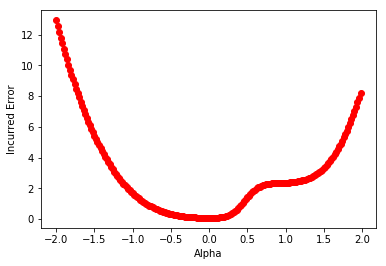

In [8]:
# 畫出我們剛剛算出來的數字
plt.plot(np.arange(-2, 2, 0.02), results, 'ro')
plt.ylabel('Incurred Error')
plt.xlabel('Alpha')
plt.show()

上圖, 我們把曲面強制設定在了一個方向上.  
這讓我們看到了`鞍點`, 同時這也解釋了上一章有時候會沒辦法收斂的原因, 其實就只是訓練不夠而已, 總是能夠繼續前進的.  
也就是說, 如果我們能夠確定前進的方向, 那麼`鞍點`是不能阻止我們的.  
此外, 在2014年還有一個研究指出, 在能夠確定方向的前提下, `局部極小值`並不會造成梯度下降過程的麻煩.  
***我們最終只有一個問題, 那就是我們要找到前進的方向.***  

---

## 4. 優化器

In [33]:
# 設定參數, 跑 50 次迭代, 每個小批次設定為128, 每 10 次迭代我們才印一次誤差
epochs=50 
batch_size=128
state=10

這邊我們重新定義訓練方法, 優化器我們用參數的方式傳遞.  
這能夠方便我們傳入不同的優化器, 使用不同的方式做迭代.

In [9]:
def training(cost, global_step, optimizer):   
    train_op = optimizer.minimize(cost, global_step=global_step)
    
    return train_op

我們將`創建模型`、`訓練模型`、`印出預測`的過程包成一個方法.  
這樣等等我們就不用重複打上這麼長的程式碼, 可以很簡潔的表達我們每次跑出一個新的模型的過程.  

In [68]:
def run_a_model(name, optimizer):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE) as scope:

        global_step_momentum = tf.Variable(0, name='global_step', trainable=False)

        h1_momentum, h2_momentum, output_momentum = inference(x)
        cost_momentum = loss(output_momentum, y)
        training_momentum = training(cost_momentum, global_step_momentum, optimizer)
        evaluate_momentum = evaluate(output_momentum, y)

        var_list_momentum = ['hidden_1/w', 'hidden_1/b', 'hidden_2/w', 'hidden_2/b', 'output/w', 'output/b']
        var_list_momentum = [tf.get_variable(v) for v in var_list_momentum]

        init_momentum = tf.global_variables_initializer()
        sess.run(init_momentum)

        for epoch in range(epochs):
            total_batch = mnist.train.num_examples//batch_size

            for i in range(total_batch):
                mbatch_x, mbatch_y = mnist.train.next_batch(batch_size)
                sess.run(training_momentum, feed_dict={x:mbatch_x, y:mbatch_y})

            if epoch % state == 0:
                train_accuracy = sess.run(evaluate_momentum, feed_dict={x:mnist.train.images, y:mnist.train.labels})
                val_accuracy = sess.run(evaluate_momentum, feed_dict={x:mnist.validation.images, y:mnist.validation.labels})
                print('Epochs:', '%04d' % (epoch+1), 'train_error:', (1-train_accuracy), 'val_error:', (1-val_accuracy))

        print('Optimization Finished!')

        accuracy = sess.run(evaluate_momentum, feed_dict={x:mnist.test.images, y:mnist.test.labels})
        print('Test Accuracy:', accuracy)

### 4.1 Momentum

源自於當我們丟一顆球在一個漏斗中, 這顆球會隨著坡度向下最終會到達漏斗底部的這個概念.  
在迭代的過程中加入了動能, 每次更新方向時判斷現在要繼續加速還是現在要減速.  
如果連續的往同樣方向前進, 那速率會提高, 我們就能更快收斂.  
但是如果方向改變, 那速率會減緩.  

In [45]:
# 使用 momentum 的演算法進行迭代
optimizer = tf.train.MomentumOptimizer(0.02, 0.9)
run_a_model('momentum', optimizer)

Epochs: 0001 train_error: 0.144472718239 val_error: 0.154799997807
Epochs: 0011 train_error: 0.00281816720963 val_error: 0.0188000202179
Epochs: 0021 train_error: 3.6358833313e-05 val_error: 0.0175999999046
Epochs: 0031 train_error: 3.6358833313e-05 val_error: 0.0166000127792
Epochs: 0041 train_error: 1.81794166565e-05 val_error: 0.0167999863625
Optimization Finished!
Test Accuracy: 0.9815


### 4.2 AdaGrad

這是在2011年被提出的演算法, 我們在前面的優化器中, 對各個權重都是用固定的`learning rate`.  
但是我們也可以想像, 不同的參數重要性肯定是不一樣的, 因此考量每個參數用不同的`learning rate`總是一個很吸引人的想法.  
`AdaGrad`就從這裡出發, 它對過去的梯度做了平方累加, 再開根號, 接著用一開始設定的`learning rate`除這個數.  
得到的效果除了每個參數不同之外, 還會隨著迭代次數增加速率遞減, 所以一開始可以設定一個較大的`learning rate`.  
但是也由於這個特性的關係, `AdaGrad`會讓速率下降, 在很多模型中表現會比較不好.

In [34]:
# 使用 AdaGrad 進行迭代
optimizer = tf.train.AdagradOptimizer(0.05)
run_a_model('AdaGrad', optimizer)

Epochs: 0001 train_error: 0.164418160915 val_error: 0.160000026226
Epochs: 0011 train_error: 0.00474548339844 val_error: 0.0181999802589
Epochs: 0021 train_error: 0.000363647937775 val_error: 0.0149999856949
Epochs: 0031 train_error: 0.000109076499939 val_error: 0.0149999856949
Epochs: 0041 train_error: 9.08970832825e-05 val_error: 0.0149999856949
Optimization Finished!
Test Accuracy: 0.9811


### 4.3 AdaDelta

這是`AdaGrad`的修正版, 減緩了對於一開始設定的`learning rate`的依賴.  
除此之外, 也減緩了速率持續下降導致更新速度變慢的問題.  
最終的效果有點類似`momentum`, 會加速收斂的效果.

In [79]:
# 使用 AdaDelta 進行迭代
optimizer = tf.train.AdadeltaOptimizer(0.1)
run_a_model('AdaDelta', optimizer)

Epochs: 0001 train_error: 0.123000025749 val_error: 0.11519998312
Epochs: 0011 train_error: 0.0471454262733 val_error: 0.0450000166893
Epochs: 0021 train_error: 0.0316545367241 val_error: 0.033999979496
Epochs: 0031 train_error: 0.0230363607407 val_error: 0.027999997139
Epochs: 0041 train_error: 0.0185454487801 val_error: 0.0243999958038
Optimization Finished!
Test Accuracy: 0.9745


### 4.4 RMSProp

這個演算法是前面的演算法的延伸, 加入了`衰減係數`決定要保留多久以前的值來計算.  
整個演算法的效果大概介於`momentum`跟`adagrad`之間. 

In [61]:
optimizer = tf.train.RMSPropOptimizer(0.01)
run_a_model('RMSProp', optimizer)

Epochs: 0001 train_error: 0.152581810951 val_error: 0.152000010014
Epochs: 0011 train_error: 0.0217818021774 val_error: 0.0333999991417
Epochs: 0021 train_error: 0.0131999850273 val_error: 0.0296000242233
Epochs: 0031 train_error: 0.00965452194214 val_error: 0.0266000032425
Epochs: 0041 train_error: 0.00660002231598 val_error: 0.0266000032425
Optimization Finished!
Test Accuracy: 0.9761


### 4.5 Adam

這又是組合了前面, 將`momentum`與`RMSProp`做了結合.  
在整個更新過程中都會保持一個平穩的下降, 在近年越來越受歡迎.  

In [85]:
optimizer = tf.train.AdamOptimizer()
run_a_model('Adam', optimizer)

Epochs: 0001 train_error: 0.131072700024 val_error: 0.139599978924
Epochs: 0011 train_error: 0.106218159199 val_error: 0.125999987125
Epochs: 0021 train_error: 0.105709075928 val_error: 0.127200007439
Epochs: 0031 train_error: 0.106109082699 val_error: 0.124599993229
Epochs: 0041 train_error: 0.104690909386 val_error: 0.125800013542
Optimization Finished!
Test Accuracy: 0.8827


當我們的迭代碰上平緩曲面, 這種時候使用動能類型的優化器能夠加快我們脫離泥沼的速度.  
而當碰上了陡峭的曲面, 使用平穩的優化器又能夠確保不要跑太遠.  
就是因為不同的情況適合的不同的演算法, 所以有了各種各樣的優化器供我們選擇.  
因應不同的情況知道怎麼選擇演算法固然是好事.  
但是實際上在深度學習領域獲得重大突破的往往不是與誤差曲面進行搏鬥的這部分.  
而是模型的創建, 因此這一篇放在入門是希望大家看完有點印象, 但是千萬不要鑽研在這上面.